In [1]:
import os
import sys
import random
import warnings
import gc

import numpy as np
from numpy import save
from numpy import load
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images, imsave
from skimage.transform import resize
from skimage.morphology import label


from keras.models import Model, load_model
from keras.layers import Input,Cropping2D
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose,UpSampling2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.backend import int_shape
from keras.models import Sequential
from keras import backend as K

import tensorflow as tf

Using TensorFlow backend.


In [2]:
def upsample():
    inputs = Input((64,64,3))
    
    c1 = Conv2D(3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (inputs)
    c2 = Conv2D(3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
    u = UpSampling2D(size=(2,2)) (c2)
    model = Model(inputs=inputs, outputs=u)
    
    return model

In [3]:
def downsample():
    inputs = Input((256,256,3))
    c1 = Conv2D(3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (inputs)
    c2 = Conv2D(3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
    p = MaxPooling2D((2, 2)) (c2)
    c3 = Conv2D(3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p)
    c4 = Conv2D(3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
    model = Model(inputs=inputs, outputs=c4)
    
    return model   

In [4]:
def normsample():
    inputs = Input((128,128,3))
    c1 = Conv2D(3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (inputs)
    c2 = Conv2D(3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
    model = Model(inputs=inputs, outputs=c2)
    
    return model
    

In [5]:
TRAIN_PATH = '/home/quiquealon/Documents/TIA/UNET/scaling/ISIC2018_Task1-2_Training_Input-split/'
MASK_PATH = '/home/quiquealon/Documents/TIA/UNET/scaling/ISIC2018_Task1_Training_GroundTruth-split/'

train_ids = next(os.walk(TRAIN_PATH))[1]

In [7]:
# Altura y Ancho de la imagen y los canales RGB
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

X_train_down=[]
X_train_mid=[]
X_train_up=[]

Y_train=[]

for ids_ in tqdm(train_ids,total=len(train_ids)):
    for i in range(1,5):
        #Imagen original
        img=imread(TRAIN_PATH + ids_+'/'+ids_+'_'+str(i)+'.jpg')[:,:,:IMG_CHANNELS]
        #Mascara original 
    
        img_mask=imread(MASK_PATH + ids_+'/'+ids_+'_'+str(i)+'_segmentation.png')
        
       
        #Hacer crop img
#         img_cropped_1 = img[96:160,96:160]
#         img_cropped_2 = img[64:192,64:192]
        
        #Hacer crop mask
        mask_cropped_1 = img_mask[96:160,96:160]
        mask_cropped_2 = img_mask[64:192,64:192]
        
        #Agregar a las listas
        
#         X_train_down.append(img_cropped_1)
#         X_train_mid.append(img_cropped_2)
#         X_train_up.append(img)

        Y_train.append(np.expand_dims(resize(mask_cropped_1,(128,128), mode='constant',preserve_range=True),axis=-1))
        Y_train.append(np.expand_dims(mask_cropped_2,axis=-1))
        Y_train.append(np.expand_dims(resize(img_mask,(128,128), mode='constant',preserve_range=True),axis=-1))    
   
    


100%|██████████| 2594/2594 [00:50<00:00, 51.22it/s]


In [8]:
Y_train=np.asarray(Y_train)

In [9]:
Y_train=Y_train.astype(int)

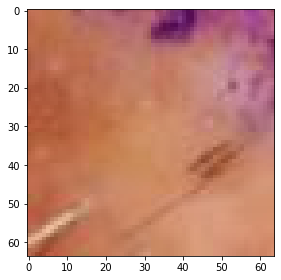

In [8]:
imshow(X_train_down[1])

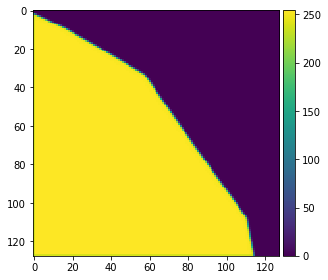

In [23]:
imshow(np.squeeze(Y_train[5]))

In [24]:
# save to npy file

# save('save/X_train_down.npy', X_train_down)
# save('save/X_train_mid.npy', X_train_mid)
# save('save/X_train_up.npy', X_train_up)
save('save/Y_train.npy', Y_train)

In [2]:
# load data from npy file

X_train_down=load('save/X_train_down.npy')
X_train_mid=load('save/X_train_mid.npy',)
X_train_up=load('save/X_train_up.npy')

# Y_train=load('save/Y_train.npy')

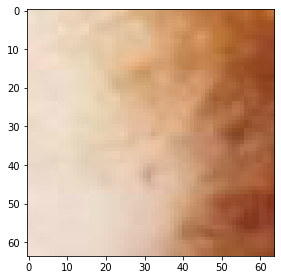

In [12]:
imshow(X_train_down[1036])

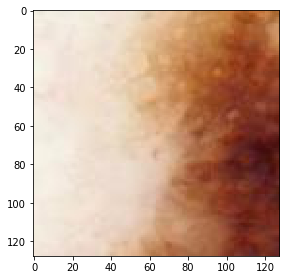

In [11]:
imshow(X_train_mid[1036])

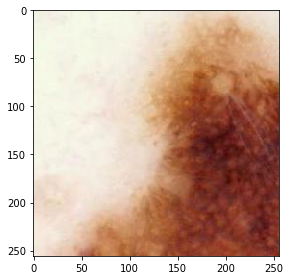

In [10]:
imshow(X_train_up[1036])

In [6]:
#Haciendo el upsample de las imagenes 64 x 64
modelDown=upsample()
modelDown.compile(optimizer='adam',loss='binary_crossentropy')
modelDown.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 3)         84        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 3)         84        
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 128, 128, 3)       0         
Total params: 168
Trainable params: 168
Non-trainable params: 0
_________________________________________________________________


In [7]:
X_train_down=np.array(X_train_down)

In [8]:
outputDown = modelDown.predict(X_train_down)

In [9]:
# save to npy file

save('save/outputDown.npy', outputDown)

In [6]:
#Haciendo el sampling de las imagenes 128 x 128
modelNorm=normsample()
modelNorm.compile(optimizer='adam',loss='binary_crossentropy')
modelNorm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 3)       84        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 3)       84        
Total params: 168
Trainable params: 168
Non-trainable params: 0
_________________________________________________________________


In [7]:
X_train_mid=np.array(X_train_mid)

In [8]:
outputNorm = modelNorm.predict(X_train_mid)

In [10]:
# save to npy file

save('save/outputNorm.npy', outputNorm)

In [6]:
#Haciendo el down sampling de las imagenes 128 x 128
modelUp=downsample()
modelUp.compile(optimizer='adam',loss='binary_crossentropy')
modelUp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 3)       84        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 3)       84        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 3)       84        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 3)       84        
Total params: 336
Trainable params: 336
Non-trainable params: 0
_________________________________________________________________


In [7]:
X_train_up=np.array(X_train_up)

In [8]:
outputUp = modelUp.predict(X_train_up)

In [9]:
# save to npy file

save('save/outputUp.npy', outputUp)

In [10]:
len(outputUp)

10376

In [2]:
# load data from npy file

outputDown=load('save/outputDown.npy')
outputNorm=load('save/outputNorm.npy',)
outputUp=load('save/outputUp.npy')

# Y_train=load('save/Y_train.npy')

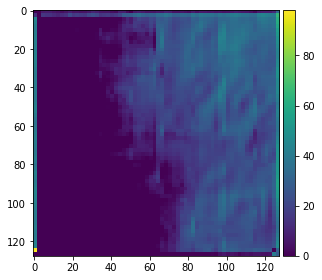

In [6]:
imshow(outputDown[1036][:, :, 0])

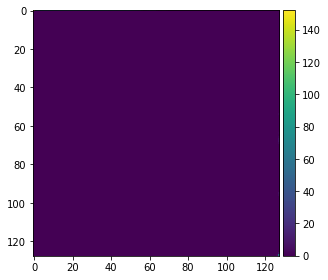

In [10]:
imshow(outputNorm[1036][:, :, 0])

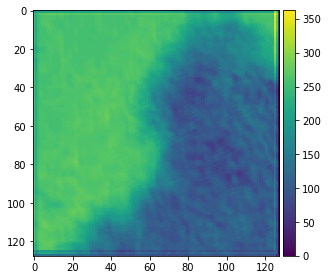

In [8]:
imshow(outputUp[1036][:, :, 0])

In [3]:
#Unir el X_train
X_train=[]

for i in range(0,len(outputUp)):
    X_train.append(outputDown[i])
    X_train.append(outputNorm[i])
    X_train.append(outputUp[i])
    
    

In [26]:
print(len(X_train))
print(len(Y_train))

31128
31128


In [5]:
# save to npy file

save('save/X_train.npy', X_train)

In [2]:
# load data from npy file

X_train=load('save/X_train.npy')
Y_train=load('save/Y_train.npy')

In [3]:
X_train[2].shape

(128, 128, 3)

In [4]:
Y_train[2].shape

(128, 128, 1)

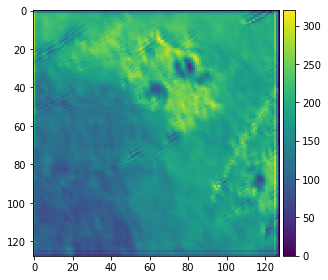

In [40]:
imshow(X_train[5][:, :, 0])

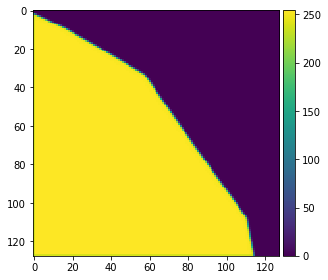

In [6]:
imshow(np.squeeze(Y_train[5]))

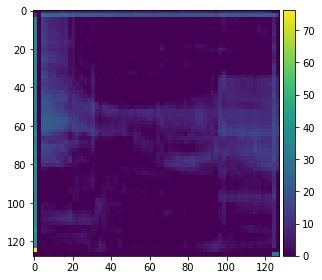

In [8]:
imshow(X_train[1035][:, :, 0])

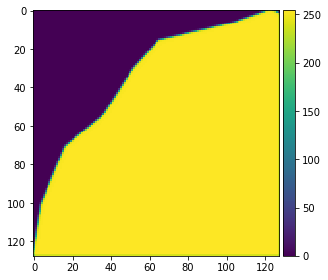

In [33]:
imshow(np.squeeze(Y_train[2]))

In [3]:
Y_train=Y_train.astype(bool)

In [4]:
def jaccard_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true + y_pred)
    jac = (intersection + 1.) / (union - intersection + 1.)
    return K.mean(jac)

In [5]:
def dice_coef(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
                K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [6]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [7]:
# Modelo de la U-Net

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)


In [8]:
#binary_crossentropy

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef,jaccard_coef])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [9]:
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=15)

model.save('Modelo_v002_scale.h5')

Train on 28015 samples, validate on 3113 samples
Epoch 1/15
28015/28015 [==============================] - 787s 28ms/step - loss: 0.3022 - dice_coef: 0.8911 - jaccard_coef: 0.8049 - val_loss: 0.2885 - val_dice_coef: 0.8799 - val_jaccard_coef: 0.7880
Epoch 2/15
28015/28015 [==============================] - 817s 29ms/step - loss: 0.2518 - dice_coef: 0.9102 - jaccard_coef: 0.8361 - val_loss: 0.2332 - val_dice_coef: 0.9103 - val_jaccard_coef: 0.8375
Epoch 3/15
28015/28015 [==============================] - 780s 28ms/step - loss: 0.2406 - dice_coef: 0.9143 - jaccard_coef: 0.8429 - val_loss: 0.2353 - val_dice_coef: 0.9143 - val_jaccard_coef: 0.8443
Epoch 4/15
28015/28015 [==============================] - 791s 28ms/step - loss: 0.2350 - dice_coef: 0.9162 - jaccard_coef: 0.8461 - val_loss: 0.2395 - val_dice_coef: 0.9080 - val_jaccard_coef: 0.8337
Epoch 5/15
28015/28015 [==============================] - 778s 28ms/step - loss: 0.2308 - dice_coef: 0.9177 - jaccard_coef: 0.8487 - val_loss: 0.21

In [36]:
# Cargar modelo

model = load_model('Modelo_v002_scale.h5', custom_objects={'dice_coef': dice_coef,'jaccard_coef':jaccard_coef})

In [10]:
# Obtener imagenes redimensionadas para el test

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TEST_PATH = '/home/quiquealon/Documents/TIA/UNET/ISIC2018_Task1-2_Validation_Input-redimensionada/'
test_ids = next(os.walk(TEST_PATH))[2]


X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Obteniendo imágenes redimensionadas de prueba. ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    X_test[n] = img
    
print('Carga Terminada!')

Obteniendo imágenes redimensionadas de prueba. ... 


100%|██████████| 100/100 [00:00<00:00, 282.96it/s]

Carga Terminada!


In [11]:
# Predecir en validation test

preds_test = model.predict(X_test, verbose=1)

100/100 [==============================] - 1s 15ms/step


In [45]:
preds_test_t = (preds_test > 0.7).astype(np.uint8)

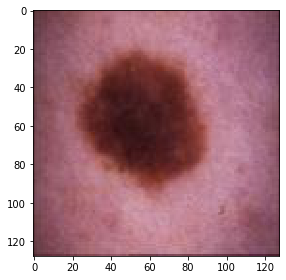

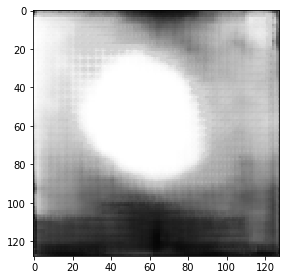

In [90]:
ix = random.randint(0, len(X_test))

imshow(X_test[ix])
plt.show()

imshow(np.squeeze(preds_test[ix]))
plt.show()
